Домашнее задание по исследованию различных показателей на соревнованиях по пауэрлифтингу

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from itertools import *

In [2]:
df = pd.read_csv('drive/MyDrive/МИСиС/ML/input.csv')
lor = df.columns.tolist()
df.head(4)

,Name,Sex,Age,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Tested,Federation,Date,MeetCountry,MeetTown
0,Billy Hernandez,M,24.0,Open,59.96,60,152.5,105.0,197.5,455.0,1,384.25,NaN,USPA,2015-01-10,USA,Oceanside
1,Shon Paul Dukes,M,15.0,MR-O,65.20,66,92.5,75.0,145.0,312.5,3,247.09,Yes,USAPL,2015-01-10,USA,NaN
2,Michael Gintzler,M,20.5,MR-O,71.30,74,170.0,112.5,212.5,495.0,1,367.16,Yes,USAPL,2015-01-10,USA,NaN
3,Daniel Vanderberg,M,27.5,MR-O,70.90,74,167.5,115.0,195.0,477.5,3,355.54,Yes,USAPL,2015-01-10,USA,NaN


Для начала анализа данных, сначала надо привести их в приемлимый вид.
Удалим все строки, где столбцы с максимальным весом любого из движений отсутствует или отрицательный. Также удалим те строки, где отсутствует вес спортсмена, тк это очень важный показатель. 

In [14]:
for i in range(6, 9):
    df = df[(df[lor[i]].isna() == False) & (df[lor[i]] > 0)]
df = df[df[lor[4]].isna() == False]
print(df.shape[0])

172095


Основываясь на данных о лучших взятых весах в каждом движении посчитаем суммарный вес.

In [4]:
def cnt_total(row):
    if(pd.isnull(row[9])):
        return row[6:9].sum()
    else:
        return row[9]
        
df["TotalKg"] = df.apply(cnt_total, axis=1)

In [5]:
print(df.isna().sum())

Name                   0
Sex                    0
Age                10850
Division              51
BodyweightKg           0
WeightClassKg          7
Best3SquatKg           0
Best3BenchKg           0
Best3DeadliftKg        0
TotalKg                0
Place                  0
Dots                 178
Tested             56901
Federation             0
Date                   0
MeetCountry            0
MeetTown           78941
dtype: int64


#Проверка распределения показателей на номальность


Для начала проведем визуальный анализ
По графикам точно можно сказать, что возраст распределен не нормально - что неудивительно.

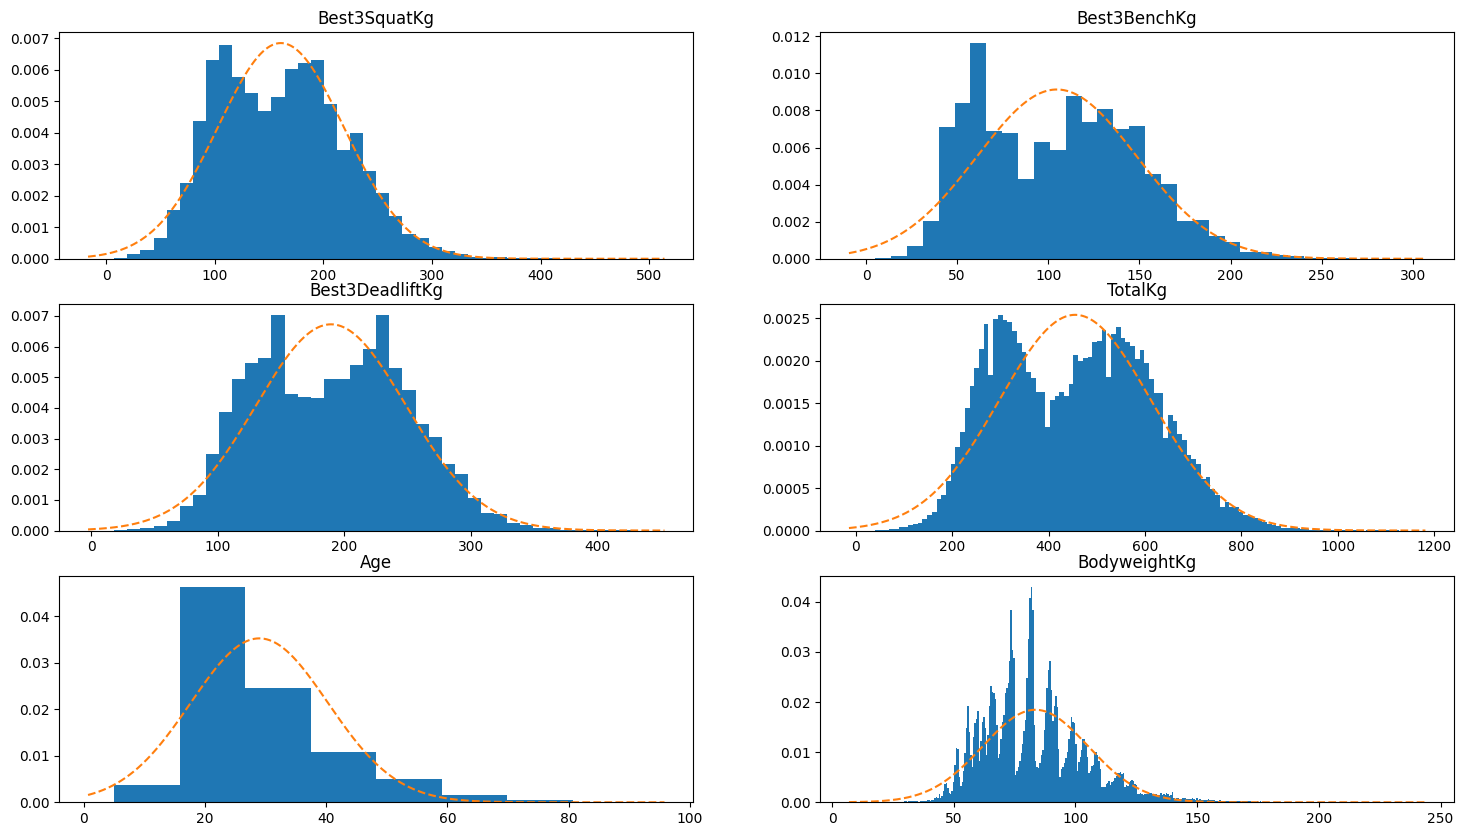

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(18, 10))
keys = lor[6:10] 
keys.append(lor[2])
keys.append(lor[4])

for i in range (0, 6):
  cur_ax = axes[i//2, i % 2]
  cur_ax.hist(df[keys[i]], density = True, bins = len(df[keys[i]].unique()) // 20)
  cur_ax.set_title(keys[i])

  loc = df[keys[i]].mean()
  scale = df[keys[i]].std()
 
  x_left, x_right = cur_ax.get_xlim()
  
  x = np.linspace(x_left, x_right, 10000)
  y = stats.norm.pdf(x, loc=loc, scale=scale)
   
  cur_ax.plot(x, y, linestyle='dashed')


Построим графики Q-Q для визуализации отклонений квентилий от нормального распределения.

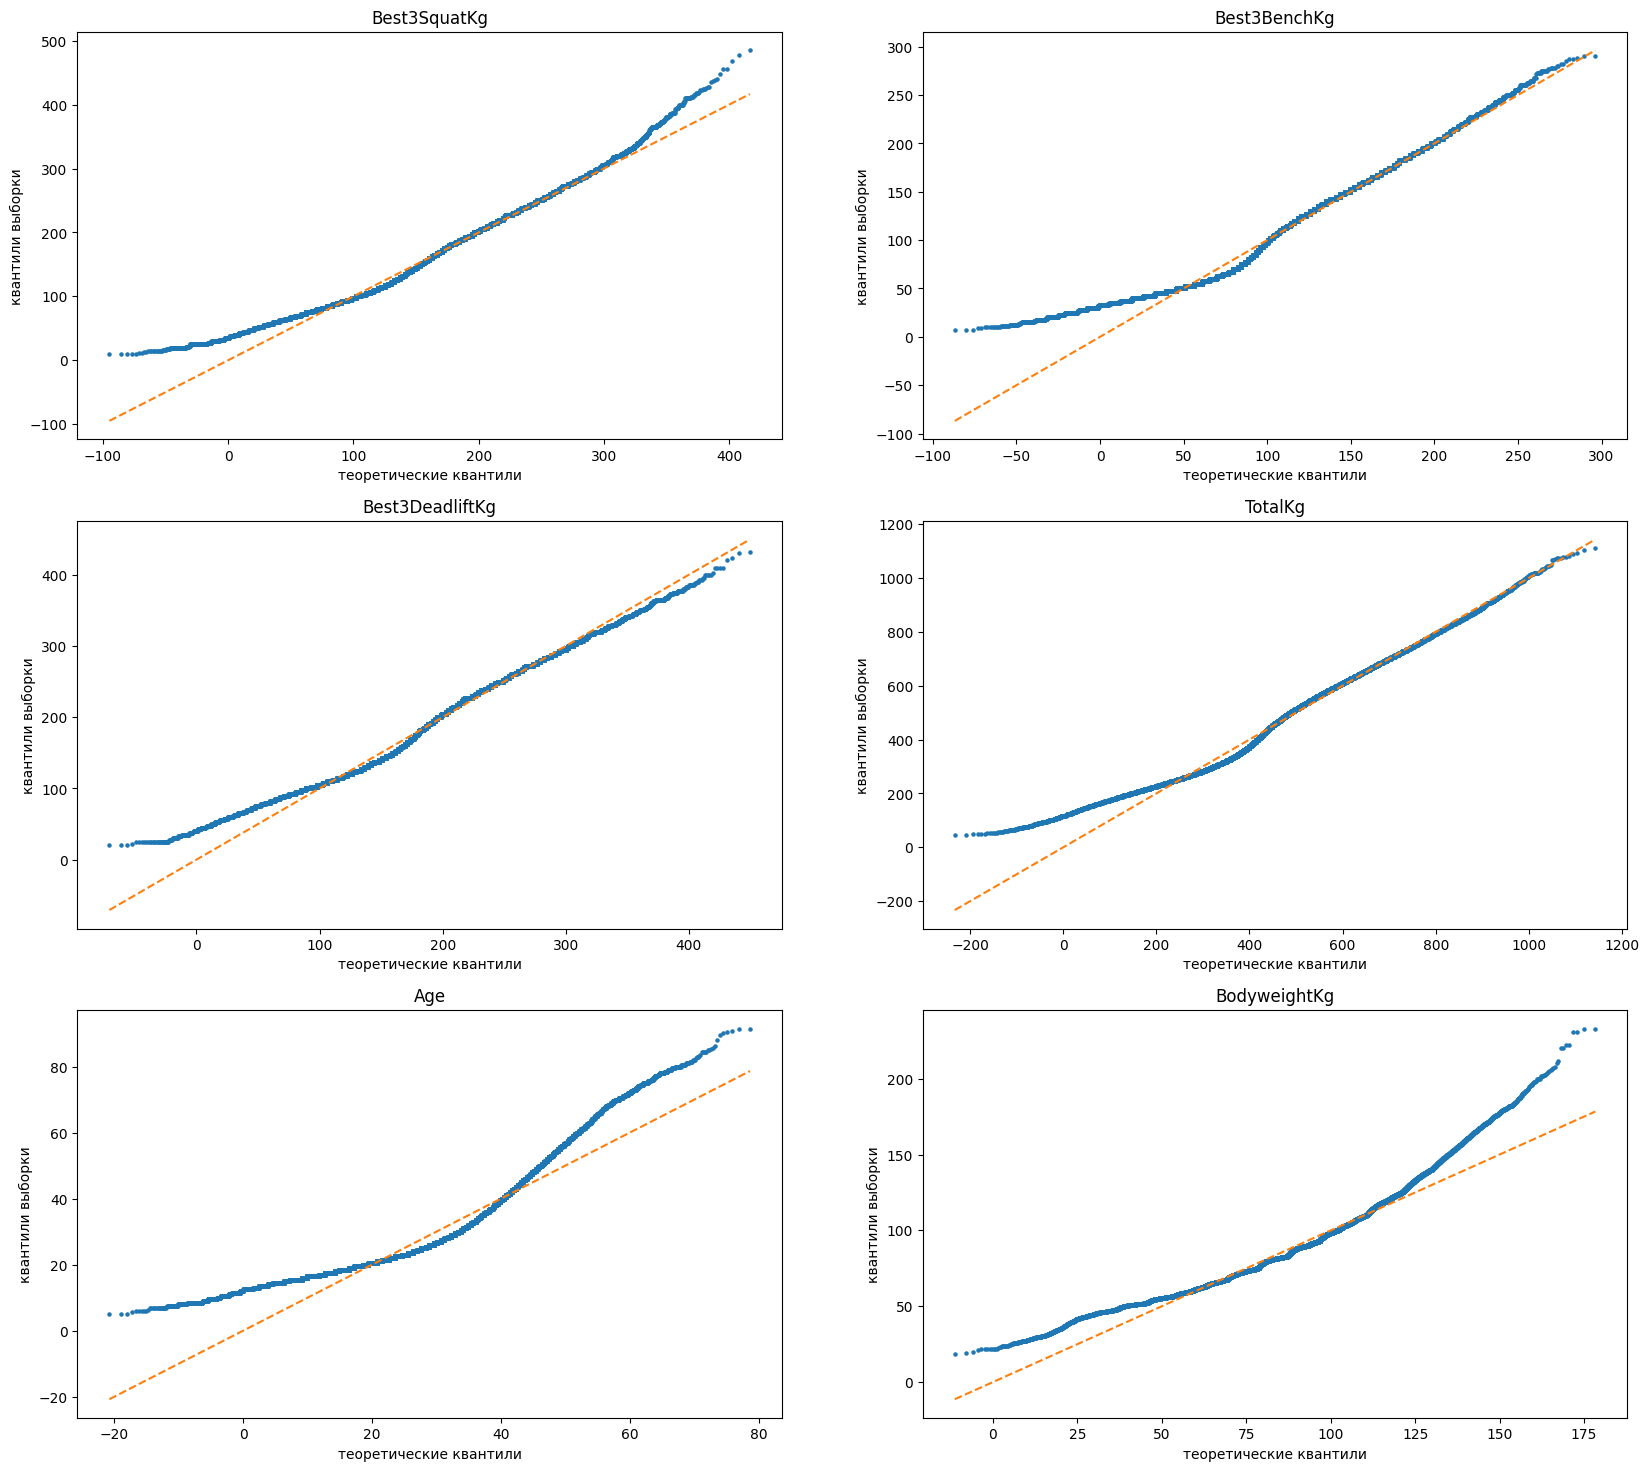

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
keys = lor[6:10] 
keys.append(lor[2])
keys.append(lor[4])

for i in range (0, 6):
  cur_ax = axes[i//2, i % 2]

  loc = df[keys[i]].mean()
  scale = df[keys[i]].std()
  
  interval = np.linspace(0, 1, df[keys[i]].shape[0])[1:-1]
  x = stats.norm.ppf(interval, loc=loc, scale=scale)

  y = np.nanquantile(df[keys[i]], interval)

  cur_ax.scatter(x, y, s=5)
  cur_ax.plot(x, x, color='C1', linestyle='dashed')
  
  cur_ax.set_title(keys[i])
  cur_ax.set_xlabel('теоретические квантили')
  cur_ax.set_ylabel('квантили выборки')

Подойдем более строго к анализу и вычислим реальные значения для разных квентилей, а также их теоретические значения - заметим, что параметр веса спортсмена получился нормальным, с малейшими отклонениями от теоретических значений.

In [7]:
for key in keys:
  cur_col = df[key]

  loc = cur_col.mean()
  scale = cur_col.std()
  print(key)
  for i in range(1, 4):
    theor_val = stats.norm.cdf(i) - stats.norm.cdf(-i)
    real_val = ((cur_col >= loc - i * scale) & (cur_col <= loc + i * scale)).sum() / cur_col.shape[0]
    print(f'{i} sigma(s)')
    print(f'\ttheoretical:\t{theor_val}')
    print(f'\tsample:\t\t{real_val}')
  print()

Best3SquatKg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6400244051250763
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9684360382346959
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9975885412127022

Best3BenchKg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6185130305935675
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9738923269124612
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9982044800836747

Best3DeadliftKg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6244516110287922
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9747290740579331
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.999349196664633

TotalKg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6260553763909469
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.975124204654406
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9988727156512391

Age
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.701664778174

Рассмотрим зависимость веса спортсмена и тоннаж который он поднял в сумме трех движений

Text(0, 0.5, 'BodyweightKg')

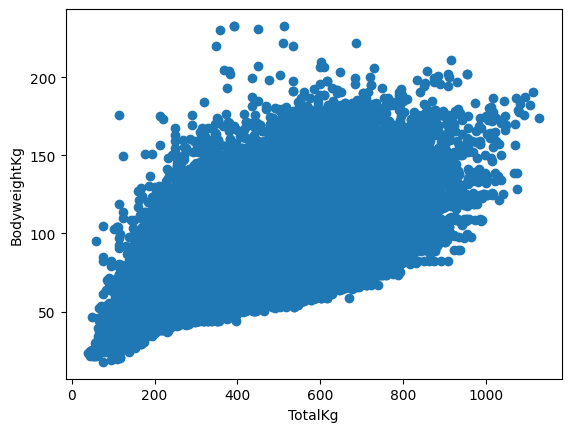

In [8]:
plt.scatter(df[keys[3]], df[keys[5]])
plt.xlabel(keys[3])
plt.ylabel(keys[5])

In [9]:
x = np.array(df['TotalKg']).reshape(-1, 1)
y = np.array(df['BodyweightKg'])
model = LinearRegression().fit(x, y)
R2 = model.score(x, y)
print('коэф детерминации', R2)



коэф детерминации 0.41643007416842737


In [10]:
n = df.shape[0]
m = 1
k1 = m
k2 = n - m - 1
alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
print(t)
F = (R2 / k1) / ((1 - R2) / k2)
print(F)

3.8415128568489902
122803.96501198507


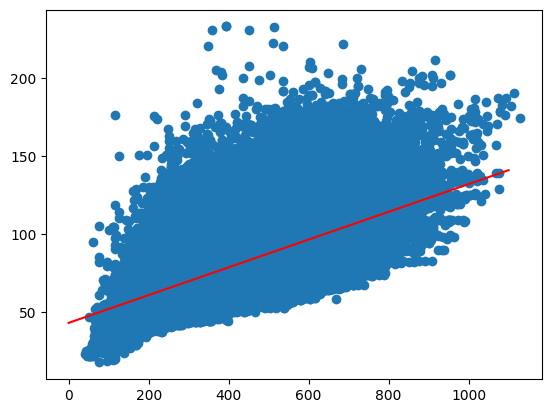

In [11]:
b = model.intercept_
k = float(model.coef_)
x = np.linspace(0, 1100, 100000)
y = k*x + b

plt.scatter(df[keys[3]], df[keys[5]])

plt.plot(x, y, color = 'r')
plt.show()

Для того, чтобы изучить как влияют друг на друга разные параметры - построим матрицу корреляции.

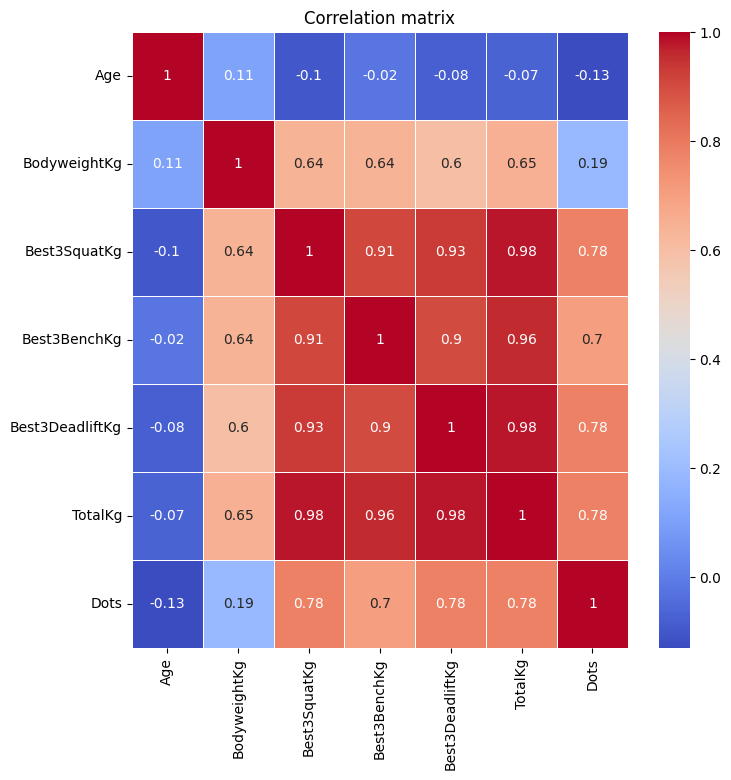

In [13]:
corrdf = df.copy()

plt.figure(figsize = (8,8))


corrdf = corrdf.corr()
corrdf = np.round(corrdf, 2)

sns.heatmap(corrdf, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()